### Process data from CDP Full Cities 2021 dataset (provided by Felipe)

In [2]:
import os

import fasttext
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from google.cloud import translate_v2 as translate
from tqdm import tqdm

In [3]:
# enables tqdm for pandas
tqdm.pandas()

In [4]:
# google api key
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'project-hunter-379918-694c8224f026.json'

In [5]:
# load csv as dataframe
df_csv = pd.read_csv('csvs/es.csv', sep=',')
df_csv

,Questionnaire Name,Account Number,Account Name,Country,CDP Region,Sector,Title,Description
0,Cities 2021,31154,Bogotá Distrito Capital,Colombia,Latin America,NaN,NaN,NaN
1,Cities 2021,31155,City of Buenos Aires,Argentina,Latin America,Water management,Restauración Arroyo Medrano en Parque Saavedra,El proyecto contempla la restauración de 530 m...
2,Cities 2021,31155,City of Buenos Aires,Argentina,Latin America,Water management,Activación Reservorio Arroyo cildañez,Se contempla la posibilidad de crear espacios ...
3,Cities 2021,31155,City of Buenos Aires,Argentina,Latin America,"Other, please specify: Urbanismo sostenible",Despavimentación,El proyecto contempla la adecuación de diferen...
4,Cities 2021,31155,City of Buenos Aires,Argentina,Latin America,Water management,Centro interpretación del Agua,Visitas de escuelas a un espacio en el que se ...
...,...,...,...,...,...,...,...,...
1738,Cities 2019,841154,Municipalidad de Independencia (Peru),Peru,Latin America,Other: Planta de tratamiento de aguas residual...,Planta de tratamiento de aguas residuales,tratar el agua hervida para convertirlas en ag...
1739,Cities 2019,841155,Municipalidad de Tarapoto,Peru,Latin America,NaN,NaN,NaN
1740,Cities 2019,841269,Municipalidad de Montecarlo,Argentina,Latin America,NaN,NaN,NaN
1741,Cities 2019,841326,Municipalidad de Oro Verde,Argentina,Latin America,NaN,NaN,NaN


In [6]:
df_csv['Questionnaire Name'].value_counts()

Cities 2021    603
Cities 2019    602
Cities 2020    538
Name: Questionnaire Name, dtype: int64

In [7]:
# select only relevant columns
df_relevant = df_csv[['Sector', 'Title', 'Description']].rename(columns={'Sector': 'area', 'Title': 'title', 'Description': 'desc'})
df_relevant

,area,title,desc
0,NaN,NaN,NaN
1,Water management,Restauración Arroyo Medrano en Parque Saavedra,El proyecto contempla la restauración de 530 m...
2,Water management,Activación Reservorio Arroyo cildañez,Se contempla la posibilidad de crear espacios ...
3,"Other, please specify: Urbanismo sostenible",Despavimentación,El proyecto contempla la adecuación de diferen...
4,Water management,Centro interpretación del Agua,Visitas de escuelas a un espacio en el que se ...
...,...,...,...
1738,Other: Planta de tratamiento de aguas residual...,Planta de tratamiento de aguas residuales,tratar el agua hervida para convertirlas en ag...
1739,NaN,NaN,NaN
1740,NaN,NaN,NaN
1741,NaN,NaN,NaN


In [8]:
# drop rows with no area
df_clean_area = df_relevant.dropna(subset='area')
df_clean_area

,area,title,desc
1,Water management,Restauración Arroyo Medrano en Parque Saavedra,El proyecto contempla la restauración de 530 m...
2,Water management,Activación Reservorio Arroyo cildañez,Se contempla la posibilidad de crear espacios ...
3,"Other, please specify: Urbanismo sostenible",Despavimentación,El proyecto contempla la adecuación de diferen...
4,Water management,Centro interpretación del Agua,Visitas de escuelas a un espacio en el que se ...
5,Water management,Plan de Adaptación Hidráulica al Cambio Climático,Proyecto producto del proyecto de cooperación ...
...,...,...,...
1731,Water management,Proteção e Recuperação de Nascentes do Ribeirã...,Mapeamento do manancial de abastecimento públi...
1733,No relevant projects,NaN,NaN
1736,Waste management,NaN,NaN
1737,Outdoor lighting,CONVENIO DE COOPERACION INSTITUCIONAL ENTRE LA...,Sustitución de luminarias del alumbrado publi...


In [9]:
# drop rows with no title or no desc
df_clean_na = df_clean_area.dropna(subset=['title', 'desc'])
df_clean_na

,area,title,desc
1,Water management,Restauración Arroyo Medrano en Parque Saavedra,El proyecto contempla la restauración de 530 m...
2,Water management,Activación Reservorio Arroyo cildañez,Se contempla la posibilidad de crear espacios ...
3,"Other, please specify: Urbanismo sostenible",Despavimentación,El proyecto contempla la adecuación de diferen...
4,Water management,Centro interpretación del Agua,Visitas de escuelas a un espacio en el que se ...
5,Water management,Plan de Adaptación Hidráulica al Cambio Climático,Proyecto producto del proyecto de cooperación ...
...,...,...,...
1729,Waste management,Implantação do Aterro Sanitário em forma de Co...,Implantar em forma de consórcio intermunicipal...
1730,Waste recycling,Implantação Coleta Seletiva no Município de Sã...,Implantar a coleta seletiva de resíduos recicl...
1731,Water management,Proteção e Recuperação de Nascentes do Ribeirã...,Mapeamento do manancial de abastecimento públi...
1737,Outdoor lighting,CONVENIO DE COOPERACION INSTITUCIONAL ENTRE LA...,Sustitución de luminarias del alumbrado publi...


In [10]:
# convert text to lowercase
df_lower = df_clean_na.copy()
df_lower['area'] = df_lower['area'].str.lower().str.strip(' .')
df_lower['title'] = df_lower['title'].str.lower().str.strip(' .')
df_lower['desc'] = df_lower['desc'].str.lower().str.strip(' .')
df_lower

,area,title,desc
1,water management,restauración arroyo medrano en parque saavedra,el proyecto contempla la restauración de 530 m...
2,water management,activación reservorio arroyo cildañez,se contempla la posibilidad de crear espacios ...
3,"other, please specify: urbanismo sostenible",despavimentación,el proyecto contempla la adecuación de diferen...
4,water management,centro interpretación del agua,visitas de escuelas a un espacio en el que se ...
5,water management,plan de adaptación hidráulica al cambio climático,proyecto producto del proyecto de cooperación ...
...,...,...,...
1729,waste management,implantação do aterro sanitário em forma de co...,implantar em forma de consórcio intermunicipal...
1730,waste recycling,implantação coleta seletiva no município de sã...,implantar a coleta seletiva de resíduos recicl...
1731,water management,proteção e recuperação de nascentes do ribeirã...,mapeamento do manancial de abastecimento públi...
1737,outdoor lighting,convenio de cooperacion institucional entre la...,sustitución de luminarias del alumbrado publi...


In [11]:
# check fields with urls in them
pd.set_option('display.width', 120)
pd.set_option('display.max_colwidth', 120)
s_http = df_lower['desc'][df_lower['desc'].str.contains('http')]
s_http

30      zonas de 30 km: implantação de cinco novos zonas de 30 km, com medidas de acalmia do tráfego (vagas “zigzag”, áreas ...
31      infraestrutura de ciclismo: implementação de 150 km de ciclovias e ciclovias (mapear aqui: https://drive.google.com/...
52      se adjuntan algunos documentos con información del proyectos, derivado de fuentes externas y se comparte enlace del ...
64      para expandir a oferta de ciclovias e ciclovias, a cidade planeja aumentar significativamente a extensão dessas cicl...
66      a legislação municipal prevê a implantação e consolidação de quarenta e nove parques lineares na cidade. o município...
79                                                                  https://www.c40cff.org/projects/quito-electric-bus-corridor
120     se prevé la creación de un programa integral de abordaje de este colectivo, formalizando su trabajo, mejorando las c...
171                      https://www.santos.sp.gov.br/static/files_www/donwloads/municipio_verde_azul/pl

In [12]:
# drop pure url fields
df_clean_url = df_lower.drop(index=s_http[~s_http.str.contains(' ')].index)
df_clean_url

,area,title,desc
1,water management,restauración arroyo medrano en parque saavedra,el proyecto contempla la restauración de 530 metros del arroyo medrano con capacidad de retener 25.0000.000 litros d...
2,water management,activación reservorio arroyo cildañez,se contempla la posibilidad de crear espacios recreativos y educativos mediante humedales y plantación de especies a...
3,"other, please specify: urbanismo sostenible",despavimentación,el proyecto contempla la adecuación de diferentes calles de la ciudad de manera que se prioricen los espacios verdes...
4,water management,centro interpretación del agua,visitas de escuelas a un espacio en el que se presenta contenido educativo integral sobre agua y cambio climatico. a...
5,water management,plan de adaptación hidráulica al cambio climático,proyecto producto del proyecto de cooperación con copenhague. en el marco del plan hidráulico y su plan de adaptació...
...,...,...,...
1729,waste management,implantação do aterro sanitário em forma de consórcio intermunicipal de gestão de resíduos sólidos,implantar em forma de consórcio intermunicipal de gestão de resíduos sólidos o aterro sanitário para descarte ambien...
1730,waste recycling,implantação coleta seletiva no município de são luís de montes belos,implantar a coleta seletiva de resíduos recicláveis no município
1731,water management,proteção e recuperação de nascentes do ribeirão santana / empedrado,"mapeamento do manancial de abastecimento público, identificação de suas nascentes principais com ações de recuperaçã..."
1737,outdoor lighting,convenio de cooperacion institucional entre la empresa enel y la municipalidad de bellavista,sustitución de luminarias del alumbrado publico por led


In [13]:
# check the len distribution for the description
df_clean_url['desc'].str.len().sort_values()

425        0
919        1
1503       9
565       11
1106      24
        ... 
120     3975
445     3982
444     3982
1001    3984
1002    3986
Name: desc, Length: 673, dtype: int64

In [14]:
# print the entries with the least characters
df_clean_url['desc'][df_clean_url['desc'].str.len().sort_values().index][:50]

425                                                                                  
919                                                                                 0
1503                                                                        asume giz
565                                                                       sem projeto
1106                                                         costos en pesos chilenos
544                                                          costos en pesos chilenos
946                                                          se encuentra en estudios
1279                                                        transporte intermunicipal
658                                                        distric energy in the city
1194                                                       distric energy in the city
67                                                         distric energy in the city
357                                                   

In [15]:
# filter desc by length
min_desc_length = 40
df_filtered_desc = df_clean_url[df_clean_url['desc'].str.len() >= min_desc_length]
df_filtered_desc

,area,title,desc
1,water management,restauración arroyo medrano en parque saavedra,el proyecto contempla la restauración de 530 metros del arroyo medrano con capacidad de retener 25.0000.000 litros d...
2,water management,activación reservorio arroyo cildañez,se contempla la posibilidad de crear espacios recreativos y educativos mediante humedales y plantación de especies a...
3,"other, please specify: urbanismo sostenible",despavimentación,el proyecto contempla la adecuación de diferentes calles de la ciudad de manera que se prioricen los espacios verdes...
4,water management,centro interpretación del agua,visitas de escuelas a un espacio en el que se presenta contenido educativo integral sobre agua y cambio climatico. a...
5,water management,plan de adaptación hidráulica al cambio climático,proyecto producto del proyecto de cooperación con copenhague. en el marco del plan hidráulico y su plan de adaptació...
...,...,...,...
1729,waste management,implantação do aterro sanitário em forma de consórcio intermunicipal de gestão de resíduos sólidos,implantar em forma de consórcio intermunicipal de gestão de resíduos sólidos o aterro sanitário para descarte ambien...
1730,waste recycling,implantação coleta seletiva no município de são luís de montes belos,implantar a coleta seletiva de resíduos recicláveis no município
1731,water management,proteção e recuperação de nascentes do ribeirão santana / empedrado,"mapeamento do manancial de abastecimento público, identificação de suas nascentes principais com ações de recuperaçã..."
1737,outdoor lighting,convenio de cooperacion institucional entre la empresa enel y la municipalidad de bellavista,sustitución de luminarias del alumbrado publico por led


In [16]:
# check the len distribution for the title
df_filtered_desc['title'].str.len().sort_values()

200       5
354       7
883       8
329       8
30        8
       ... 
306     304
986     335
445     350
1002    350
113     352
Name: title, Length: 653, dtype: int64

In [17]:
# print the entries with the least characters
df_filtered_desc['title'][df_filtered_desc['title'].str.len().sort_values().index][:50]

200               redd+
354             salta-z
883            basura o
329            basura o
30             zonas 30
158           à definir
198           mega-bici
1156         bono solar
21           bono solar
185          eco pontos
617          bono solar
739          eco pontos
1652         compostaje
197          mega-cable
594         giro limpio
1250        bicionarios
1670        eco estufas
29          favela 2030
627         favela 2030
469         transpinula
63         av. farrapos
60         luz do saber
46         ecobarreiras
72         parque solar
229        água + limpa
652        luz do saber
1708       punto limpio
199        granja solar
1301       vá de etanol
1471       águas claras
1182       ecobarreiras
340       talca recicla
1521      talca recicla
1411      minhoca amiga
140       puntos verdes
1167      recicla sampa
406       fiva ecolair:
405       ruta organica
174      juárez recicla
226      cidade + verde
1170     zonas de 30 km
728      juárez 

In [18]:
# filter title by length
min_title_length = 7
df_filtered_title_desc = df_filtered_desc[df_filtered_desc['desc'].str.len() >= min_title_length]
df_filtered_title_desc

,area,title,desc
1,water management,restauración arroyo medrano en parque saavedra,el proyecto contempla la restauración de 530 metros del arroyo medrano con capacidad de retener 25.0000.000 litros d...
2,water management,activación reservorio arroyo cildañez,se contempla la posibilidad de crear espacios recreativos y educativos mediante humedales y plantación de especies a...
3,"other, please specify: urbanismo sostenible",despavimentación,el proyecto contempla la adecuación de diferentes calles de la ciudad de manera que se prioricen los espacios verdes...
4,water management,centro interpretación del agua,visitas de escuelas a un espacio en el que se presenta contenido educativo integral sobre agua y cambio climatico. a...
5,water management,plan de adaptación hidráulica al cambio climático,proyecto producto del proyecto de cooperación con copenhague. en el marco del plan hidráulico y su plan de adaptació...
...,...,...,...
1729,waste management,implantação do aterro sanitário em forma de consórcio intermunicipal de gestão de resíduos sólidos,implantar em forma de consórcio intermunicipal de gestão de resíduos sólidos o aterro sanitário para descarte ambien...
1730,waste recycling,implantação coleta seletiva no município de são luís de montes belos,implantar a coleta seletiva de resíduos recicláveis no município
1731,water management,proteção e recuperação de nascentes do ribeirão santana / empedrado,"mapeamento do manancial de abastecimento público, identificação de suas nascentes principais com ações de recuperaçã..."
1737,outdoor lighting,convenio de cooperacion institucional entre la empresa enel y la municipalidad de bellavista,sustitución de luminarias del alumbrado publico por led


In [19]:
# list all categories (the output) and their counts
area_count = pd.DataFrame(df_filtered_title_desc.value_counts(subset='area'))
area_count[:15]

,0
area,
waste management,116
water management,100
transport,86
waste recycling,63
energy efficiency / retrofit,50
renewable energy,28
outdoor lighting,25
buildings,22
"other, please specify: educação ambiental",4


In [20]:
# remove categories with few samples
min_sample_count = 10
area_count = area_count.rename({0: 'count'}, axis='columns')
areas_to_keep = area_count[area_count > min_sample_count].dropna().index.to_list()
area_filter = df_filtered_title_desc['area'].isin(areas_to_keep)
df_clean = df_filtered_title_desc[area_filter]
df_clean

,area,title,desc
1,water management,restauración arroyo medrano en parque saavedra,el proyecto contempla la restauración de 530 metros del arroyo medrano con capacidad de retener 25.0000.000 litros d...
2,water management,activación reservorio arroyo cildañez,se contempla la posibilidad de crear espacios recreativos y educativos mediante humedales y plantación de especies a...
4,water management,centro interpretación del agua,visitas de escuelas a un espacio en el que se presenta contenido educativo integral sobre agua y cambio climatico. a...
5,water management,plan de adaptación hidráulica al cambio climático,proyecto producto del proyecto de cooperación con copenhague. en el marco del plan hidráulico y su plan de adaptació...
6,transport,expansión de red de ciclovías,la obra consiste en la ejecución de carriles exclusivos para bicicletas implementando distintos elementos que advier...
...,...,...,...
1723,outdoor lighting,iluminação de led,o objetivo da troca das luminárias é realizar a troca gradativa dos braços para iluminação- utilizando equipamentos ...
1729,waste management,implantação do aterro sanitário em forma de consórcio intermunicipal de gestão de resíduos sólidos,implantar em forma de consórcio intermunicipal de gestão de resíduos sólidos o aterro sanitário para descarte ambien...
1730,waste recycling,implantação coleta seletiva no município de são luís de montes belos,implantar a coleta seletiva de resíduos recicláveis no município
1731,water management,proteção e recuperação de nascentes do ribeirão santana / empedrado,"mapeamento do manancial de abastecimento público, identificação de suas nascentes principais com ações de recuperaçã..."


In [21]:
# join title and description in a new column
df_clean.insert(3, 'title+desc', df_clean['title'] + '. ' + df_clean['desc'])
df_clean

,area,title,desc,title+desc
1,water management,restauración arroyo medrano en parque saavedra,el proyecto contempla la restauración de 530 metros del arroyo medrano con capacidad de retener 25.0000.000 litros d...,restauración arroyo medrano en parque saavedra. el proyecto contempla la restauración de 530 metros del arroyo medra...
2,water management,activación reservorio arroyo cildañez,se contempla la posibilidad de crear espacios recreativos y educativos mediante humedales y plantación de especies a...,activación reservorio arroyo cildañez. se contempla la posibilidad de crear espacios recreativos y educativos median...
4,water management,centro interpretación del agua,visitas de escuelas a un espacio en el que se presenta contenido educativo integral sobre agua y cambio climatico. a...,centro interpretación del agua. visitas de escuelas a un espacio en el que se presenta contenido educativo integral ...
5,water management,plan de adaptación hidráulica al cambio climático,proyecto producto del proyecto de cooperación con copenhague. en el marco del plan hidráulico y su plan de adaptació...,plan de adaptación hidráulica al cambio climático. proyecto producto del proyecto de cooperación con copenhague. en ...
6,transport,expansión de red de ciclovías,la obra consiste en la ejecución de carriles exclusivos para bicicletas implementando distintos elementos que advier...,expansión de red de ciclovías. la obra consiste en la ejecución de carriles exclusivos para bicicletas implementando...
...,...,...,...,...
1723,outdoor lighting,iluminação de led,o objetivo da troca das luminárias é realizar a troca gradativa dos braços para iluminação- utilizando equipamentos ...,iluminação de led. o objetivo da troca das luminárias é realizar a troca gradativa dos braços para iluminação- utili...
1729,waste management,implantação do aterro sanitário em forma de consórcio intermunicipal de gestão de resíduos sólidos,implantar em forma de consórcio intermunicipal de gestão de resíduos sólidos o aterro sanitário para descarte ambien...,implantação do aterro sanitário em forma de consórcio intermunicipal de gestão de resíduos sólidos. implantar em for...
1730,waste recycling,implantação coleta seletiva no município de são luís de montes belos,implantar a coleta seletiva de resíduos recicláveis no município,implantação coleta seletiva no município de são luís de montes belos. implantar a coleta seletiva de resíduos recicl...
1731,water management,proteção e recuperação de nascentes do ribeirão santana / empedrado,"mapeamento do manancial de abastecimento público, identificação de suas nascentes principais com ações de recuperaçã...",proteção e recuperação de nascentes do ribeirão santana / empedrado. mapeamento do manancial de abastecimento públic...


In [22]:
# see sample count per area
print(pd.DataFrame(df_clean.value_counts(subset='area')).rename(columns={0: 'sample_count'}).to_markdown())

| area                         |   sample_count |
|:-----------------------------|---------------:|
| waste management             |            116 |
| water management             |            100 |
| transport                    |             86 |
| waste recycling              |             63 |
| energy efficiency / retrofit |             50 |
| renewable energy             |             28 |
| outdoor lighting             |             25 |
| buildings                    |             22 |


In [23]:
# characters in all samples
df_clean['title+desc'].str.len().sum()

424036

In [24]:
# save cleaned dataset
df_clean.to_csv('csvs/es_clean.csv')

In [25]:
# load language classification model
# you can download it at https://fasttext.cc/docs/en/language-identification.html
language_model = fasttext.load_model('models/id.176.bin')

In [26]:
# classify languages for all samples
def classify_language(row):
    pred = language_model.predict(row['title+desc'])
    row['lang'] = pred[0][0][-2:]
    row['conf'] = pred[1][0]
    return row

df_lang = df_clean.progress_apply(classify_language, axis=1)
df_lang

100%|██████████| 490/490 [00:00<00:00, 1063.36it/s]


,area,title,desc,title+desc,lang,conf
1,water management,restauración arroyo medrano en parque saavedra,el proyecto contempla la restauración de 530 metros del arroyo medrano con capacidad de retener 25.0000.000 litros d...,restauración arroyo medrano en parque saavedra. el proyecto contempla la restauración de 530 metros del arroyo medra...,es,0.965170
2,water management,activación reservorio arroyo cildañez,se contempla la posibilidad de crear espacios recreativos y educativos mediante humedales y plantación de especies a...,activación reservorio arroyo cildañez. se contempla la posibilidad de crear espacios recreativos y educativos median...,es,0.957628
4,water management,centro interpretación del agua,visitas de escuelas a un espacio en el que se presenta contenido educativo integral sobre agua y cambio climatico. a...,centro interpretación del agua. visitas de escuelas a un espacio en el que se presenta contenido educativo integral ...,es,0.970352
5,water management,plan de adaptación hidráulica al cambio climático,proyecto producto del proyecto de cooperación con copenhague. en el marco del plan hidráulico y su plan de adaptació...,plan de adaptación hidráulica al cambio climático. proyecto producto del proyecto de cooperación con copenhague. en ...,es,0.977310
6,transport,expansión de red de ciclovías,la obra consiste en la ejecución de carriles exclusivos para bicicletas implementando distintos elementos que advier...,expansión de red de ciclovías. la obra consiste en la ejecución de carriles exclusivos para bicicletas implementando...,es,0.964677
...,...,...,...,...,...,...
1723,outdoor lighting,iluminação de led,o objetivo da troca das luminárias é realizar a troca gradativa dos braços para iluminação- utilizando equipamentos ...,iluminação de led. o objetivo da troca das luminárias é realizar a troca gradativa dos braços para iluminação- utili...,pt,0.995076
1729,waste management,implantação do aterro sanitário em forma de consórcio intermunicipal de gestão de resíduos sólidos,implantar em forma de consórcio intermunicipal de gestão de resíduos sólidos o aterro sanitário para descarte ambien...,implantação do aterro sanitário em forma de consórcio intermunicipal de gestão de resíduos sólidos. implantar em for...,pt,0.971052
1730,waste recycling,implantação coleta seletiva no município de são luís de montes belos,implantar a coleta seletiva de resíduos recicláveis no município,implantação coleta seletiva no município de são luís de montes belos. implantar a coleta seletiva de resíduos recicl...,pt,0.987090
1731,water management,proteção e recuperação de nascentes do ribeirão santana / empedrado,"mapeamento do manancial de abastecimento público, identificação de suas nascentes principais com ações de recuperaçã...",proteção e recuperação de nascentes do ribeirão santana / empedrado. mapeamento do manancial de abastecimento públic...,pt,0.995817


In [27]:
# print smallest confidence values
df_lang['conf'].sort_values()[:10]

113     0.400140
1321    0.449693
1565    0.504248
1598    0.654733
1148    0.683012
1355    0.704893
1370    0.768406
1234    0.771371
1322    0.817263
1202    0.820040
Name: conf, dtype: float64

In [28]:
# show least confident classifications
df_lang.loc[df_lang['conf'].sort_values()[:10].index]

,area,title,desc,title+desc,lang,conf
113,waste management,"“mejoramiento y ampliación del servicio de limpieza pública en los distritos de arequipa, alto selva alegre, cayma, ...",accessibility and improvement of solid waste collection infrastructure responds to the problem of poor service in th...,"“mejoramiento y ampliación del servicio de limpieza pública en los distritos de arequipa, alto selva alegre, cayma, ...",en,0.400140
1321,waste management,implementacion del pgirs - estudios para la valorizacion de residuos de construccion,"it will seek alternatives for the use of waste from cosntructions, seeking to optimize and minimize the final dispos...",implementacion del pgirs - estudios para la valorizacion de residuos de construccion. it will seek alternatives for ...,en,0.449693
1565,energy efficiency / retrofit,cambio total de alumbrado público por luminarias led,cambio total de alumbrado público por luminarias led. al 2022 50.000 luminarias led van a remplazar a la luminaria ...,cambio total de alumbrado público por luminarias led. cambio total de alumbrado público por luminarias led. al 2022...,es,0.504248
1598,transport,ciclovia renato della santa \t\t,"ciclovia renato della santa de 1.600 mts la cual empalmara con ciclovia zanjón maure, conectando el este con el oest...",ciclovia renato della santa \t\t. ciclovia renato della santa de 1.600 mts la cual empalmara con ciclovia zanjón mau...,es,0.654733
1148,transport,rehabilitación y ampliación marginal de ciclovias,the project consists in rehabilitating and extending several cycle paths in the main avenues of the city,rehabilitación y ampliación marginal de ciclovias. the project consists in rehabilitating and extending several cycl...,en,0.683012
1355,renewable energy,geração de energia a partir de resíduos sólidos urbanos domiciliares,está sendo desenvolvido o modal tecnológico para posterior busca de parceiros,geração de energia a partir de resíduos sólidos urbanos domiciliares. está sendo desenvolvido o modal tecnológico pa...,pt,0.704893
1370,waste recycling,selective collect,selective collection in 100% gives urban area of the municipality,selective collect. selective collection in 100% gives urban area of the municipality,en,0.768406
1234,waste management,"mejoramiento y construccion de vias, y acopio de residuos solidos",accessibility and improvement of solid waste collection infrastructure responds to the problem of poor service in th...,"mejoramiento y construccion de vias, y acopio de residuos solidos. accessibility and improvement of solid waste coll...",en,0.771371
1322,water management,adquisicion de predios de importancia ecologica - mantenimiento de predios y pago por servicios ambientales,"the purchase of areas of strategic importance for the supply of aqueducts at the municipal level is carried out, in ...",adquisicion de predios de importancia ecologica - mantenimiento de predios y pago por servicios ambientales. the pur...,en,0.817263
1202,waste management,selective collection of urban waste,"implementation of vehicles for the collection of recyclable waste and 3 cooperatives, i emphasize that the project f...",selective collection of urban waste. implementation of vehicles for the collection of recyclable waste and 3 coopera...,en,0.820040


In [29]:
# show frequency distribution for lanugages
df_lang['lang'].value_counts()

es    294
pt    153
en     43
Name: lang, dtype: int64

In [30]:
# get only non-english texts
df_no_en = df_lang[df_lang['lang'] != 'en']
df_no_en

,area,title,desc,title+desc,lang,conf
1,water management,restauración arroyo medrano en parque saavedra,el proyecto contempla la restauración de 530 metros del arroyo medrano con capacidad de retener 25.0000.000 litros d...,restauración arroyo medrano en parque saavedra. el proyecto contempla la restauración de 530 metros del arroyo medra...,es,0.965170
2,water management,activación reservorio arroyo cildañez,se contempla la posibilidad de crear espacios recreativos y educativos mediante humedales y plantación de especies a...,activación reservorio arroyo cildañez. se contempla la posibilidad de crear espacios recreativos y educativos median...,es,0.957628
4,water management,centro interpretación del agua,visitas de escuelas a un espacio en el que se presenta contenido educativo integral sobre agua y cambio climatico. a...,centro interpretación del agua. visitas de escuelas a un espacio en el que se presenta contenido educativo integral ...,es,0.970352
5,water management,plan de adaptación hidráulica al cambio climático,proyecto producto del proyecto de cooperación con copenhague. en el marco del plan hidráulico y su plan de adaptació...,plan de adaptación hidráulica al cambio climático. proyecto producto del proyecto de cooperación con copenhague. en ...,es,0.977310
6,transport,expansión de red de ciclovías,la obra consiste en la ejecución de carriles exclusivos para bicicletas implementando distintos elementos que advier...,expansión de red de ciclovías. la obra consiste en la ejecución de carriles exclusivos para bicicletas implementando...,es,0.964677
...,...,...,...,...,...,...
1723,outdoor lighting,iluminação de led,o objetivo da troca das luminárias é realizar a troca gradativa dos braços para iluminação- utilizando equipamentos ...,iluminação de led. o objetivo da troca das luminárias é realizar a troca gradativa dos braços para iluminação- utili...,pt,0.995076
1729,waste management,implantação do aterro sanitário em forma de consórcio intermunicipal de gestão de resíduos sólidos,implantar em forma de consórcio intermunicipal de gestão de resíduos sólidos o aterro sanitário para descarte ambien...,implantação do aterro sanitário em forma de consórcio intermunicipal de gestão de resíduos sólidos. implantar em for...,pt,0.971052
1730,waste recycling,implantação coleta seletiva no município de são luís de montes belos,implantar a coleta seletiva de resíduos recicláveis no município,implantação coleta seletiva no município de são luís de montes belos. implantar a coleta seletiva de resíduos recicl...,pt,0.987090
1731,water management,proteção e recuperação de nascentes do ribeirão santana / empedrado,"mapeamento do manancial de abastecimento público, identificação de suas nascentes principais com ações de recuperaçã...",proteção e recuperação de nascentes do ribeirão santana / empedrado. mapeamento do manancial de abastecimento públic...,pt,0.995817


In [31]:
# total characters in non-english texts
df_no_en['title+desc'].str.len().sum()

402556

In [32]:
# translate the texts to english
def translate_row(row, translate_client):
    lang = row['lang']
    if lang == 'en':
        return row['title+desc']
    else:
        result = translate_client.translate(row['title+desc'], target_language='en')
        return result['translatedText']


translate_client = translate.Client()
df_translated = df_lang[['title+desc', 'lang']].progress_apply(translate_row, axis=1, args=(translate_client,))
df_translated

100%|██████████| 490/490 [02:45<00:00,  2.96it/s]


1       Arroyo Medrano restoration in Parque Saavedra. The project contemplates the restoration of 530 meters of the Medrano...
2       cildañez stream reservoir activation. The possibility of creating recreational and educational spaces through wetlan...
4       water interpretation center School visits to a space where comprehensive educational content on water and climate ch...
5       hydraulic adaptation plan to climate change. project product of the cooperation project with copenhagen. Within the ...
6       expansion of the bike path network. The work consists of the execution of exclusive lanes for bicycles implementing ...
                                                                 ...                                                           
1723    led lighting. The purpose of changing the light fixtures is to gradually change the arms for lighting - using more s...
1729    implementation of the sanitary landfill in the form of an intermunicipal solid waste management 

In [33]:
# save the translations to save credits
df_translated.to_csv('csvs/es_translated.csv')

In [34]:
# name the series so that it can be joined to a dataframe
df_translated.name = 'translated'
df_translated

1       Arroyo Medrano restoration in Parque Saavedra. The project contemplates the restoration of 530 meters of the Medrano...
2       cildañez stream reservoir activation. The possibility of creating recreational and educational spaces through wetlan...
4       water interpretation center School visits to a space where comprehensive educational content on water and climate ch...
5       hydraulic adaptation plan to climate change. project product of the cooperation project with copenhagen. Within the ...
6       expansion of the bike path network. The work consists of the execution of exclusive lanes for bicycles implementing ...
                                                                 ...                                                           
1723    led lighting. The purpose of changing the light fixtures is to gradually change the arms for lighting - using more s...
1729    implementation of the sanitary landfill in the form of an intermunicipal solid waste management 

In [35]:
# join translations to dataframe and select final columns
df_final = pd.merge(df_lang, df_translated, left_index=True, right_index=True)
df_final = df_final[['area', 'translated']].rename(columns={'translated': 'title+desc'})
df_final['title+desc'] = df_final['title+desc'].str.lower()
df_final

,area,title+desc
1,water management,arroyo medrano restoration in parque saavedra. the project contemplates the restoration of 530 meters of the medrano...
2,water management,cildañez stream reservoir activation. the possibility of creating recreational and educational spaces through wetlan...
4,water management,water interpretation center school visits to a space where comprehensive educational content on water and climate ch...
5,water management,hydraulic adaptation plan to climate change. project product of the cooperation project with copenhagen. within the ...
6,transport,expansion of the bike path network. the work consists of the execution of exclusive lanes for bicycles implementing ...
...,...,...
1723,outdoor lighting,led lighting. the purpose of changing the light fixtures is to gradually change the arms for lighting - using more s...
1729,waste management,implementation of the sanitary landfill in the form of an intermunicipal solid waste management consortium. implemen...
1730,waste recycling,implementation of selective collection in the municipality of são luís de montes belos. implement the selective coll...
1731,water management,"protection and restoration of springs in the santana / empedrado stream. mapping of the public supply source, identi..."


In [36]:
# save the final dataframe
df_final.to_csv('csvs/es_final.csv', index=False)

In [37]:
# dataframe with list of words for each sample
df_word_list = df_final['title+desc'].str.replace('[],.()-+:;?=*]', '', regex=True).str.split()
df_word_list

1       [arroyo, medrano, restoration, in, parque, saavedra, the, project, contemplates, the, restoration, of, 530, meters, ...
2       [cildañez, stream, reservoir, activation, the, possibility, of, creating, recreational, and, educational, spaces, th...
4       [water, interpretation, center, school, visits, to, a, space, where, comprehensive, educational, content, on, water,...
5       [hydraulic, adaptation, plan, to, climate, change, project, product, of, the, cooperation, project, with, copenhagen...
6       [expansion, of, the, bike, path, network, the, work, consists, of, the, execution, of, exclusive, lanes, for, bicycl...
                                                                 ...                                                           
1723    [led, lighting, the, purpose, of, changing, the, light, fixtures, is, to, gradually, change, the, arms, for, lightin...
1729    [implementation, of, the, sanitary, landfill, in, the, form, of, an, intermunicipal, solid, wast

Text(0.5, 0.98, 'Histogram of words per sample')

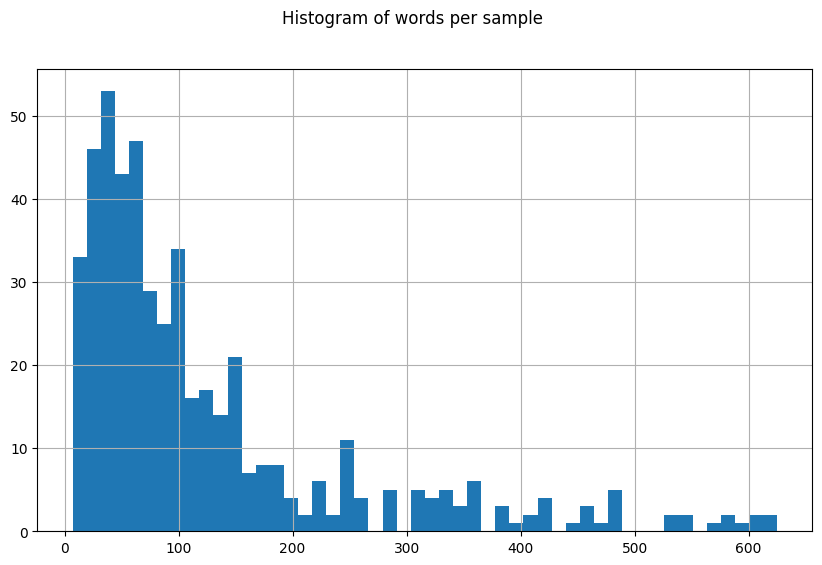

In [38]:
# histogram of words per sample
df_word_list.apply(lambda r: len(r)).hist(bins=50, figsize=(10, 6))
plt.suptitle('Histogram of words per sample')

Text(0.5, 0.98, 'Frequency of the 50 most common words in the dataset')

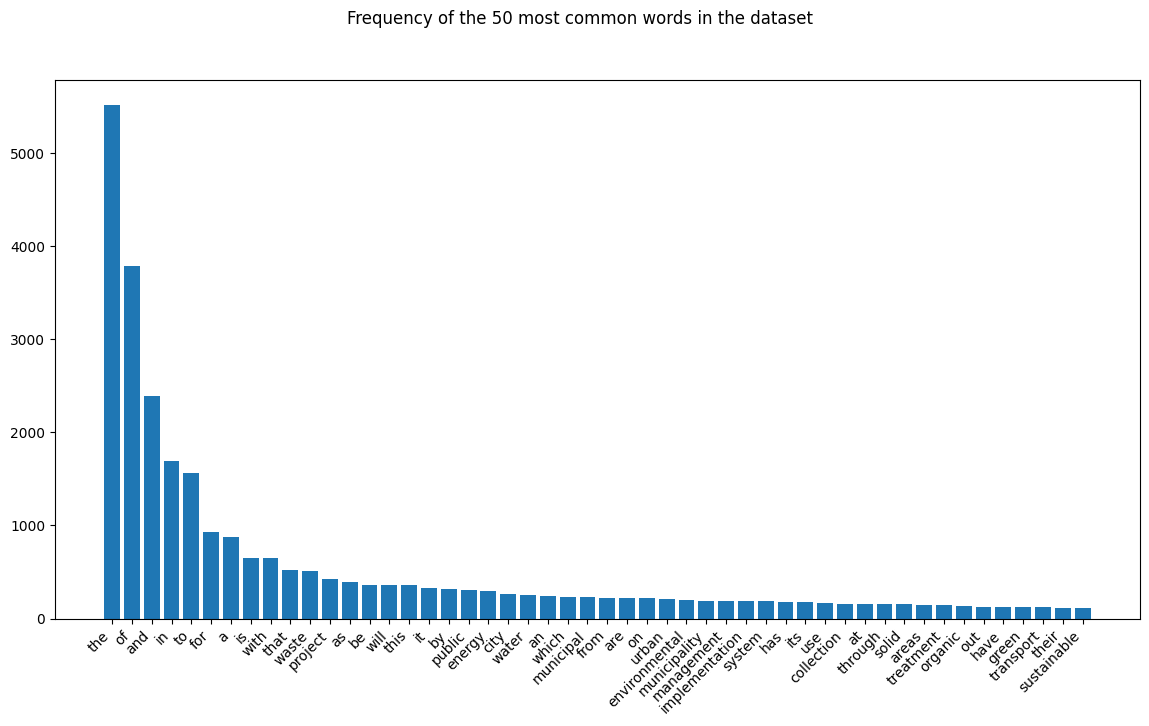

In [39]:
# frequency graph for the most common words
num_words = 50
words = df_word_list.agg('sum')
uniques, unique_counts = np.unique(words, return_counts=True)
sorted_index = np.argsort(unique_counts)[::-1]
plt.figure(figsize=(14, 7))
plt.xticks(rotation=45, ha='right')
plt.bar(uniques[sorted_index][:num_words], unique_counts[sorted_index][:num_words])
plt.suptitle(f'Frequency of the {num_words} most common words in the dataset')

In [40]:

# samples / number of words per sample ratio
# metric suggested by google to determine the approach to solving the problem
# ratio < 1500 suggests tokenizing text as n-grams instead of tokenizing as sequences
# in other words, a small ratio suggests we use simpler approaches to the problem
df_words_per_sample = df_word_list.apply(lambda r: len(r))
ratio = len(df_words_per_sample) / df_words_per_sample.mean()
ratio

3.9323266402437027